In [1]:
# conda activate chronocell

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("code"))
from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")
# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [2]:
random_seed = 666

In [3]:
# Splicing rate
beta_mu = 2
beta_sd = 0.5

# Transcription rate
alpha_mu = np.log(2) # 2
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 46
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5

# # # Read depth
# rd_mu = 0.25
# rd_var = 1/64

In [4]:
n = 100 # No. cells per lineage
p = 1 # No. genes
topo = np.array([[0, 1, 2]])
tau = (0, 5, 10)

In [5]:
theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, deg_rate_mu, deg_rate_sd, random_seed=random_seed)
Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)

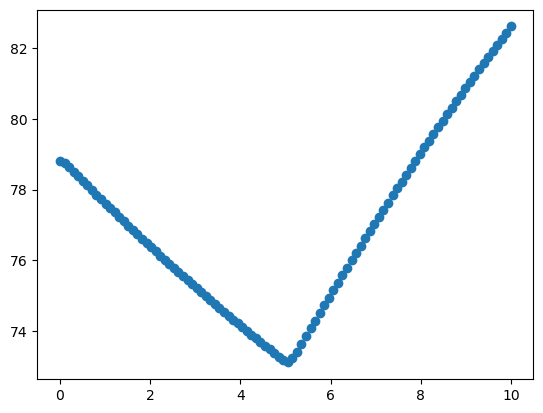

In [6]:
plt.scatter(true_t, Y[:,0,1])

In [7]:
np.random.seed(random_seed)

L = len(topo) # No. lineages
n = Y.shape[0] // L # No. cells per lineage
p = Y.shape[1] # No. genes

y0 = Y[0, :, 1] # RNA levels at state 0
ss_rate = phi[:,0] / phi[:,-1] # Steady-state protein production rate
p0 = ss_rate * y0 # Initial protein abundance assuming steady-state


In [25]:
L = len(topo) # No. lineages
n = Y.shape[0] // L # No. cells per lineage
p = Y.shape[1] # No. genes

y0 = Y[0, :, 1] # RNA levels at state 0
ss_rate = phi[:,0] / phi[:,-1] # Steady-state protein production rate
p0 = ss_rate * y0 # Initial protein abundance assuming steady-state

# Protein production paramters:
transl_rate = phi[:,0].T
deg_rate = phi[:,-1].reshape((1, -1))

P = np.zeros((n*L, p))

In [26]:
t_l = true_t[true_l == l]
dt = np.diff(t_l, prepend=t_l[0])
t_l = true_t[true_l == l].reshape((-1, 1)) # Time points/cells in lineage l     
y_l = Y[l*n:(l+1)*n, :, 1] # Spliced RNAs for lineage l

p_l = p0 * np.exp(-deg_rate * t_l) # Pre-existing protein that has not yet degraded

t_diff = t_l - t_l.T # Rows = target time; columns = past times; e.g. t_diff[m, i] = time difference between t_m and t_i 
decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) # Decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i for gene p
mask = (t_diff >= 0)[:, :, None]
mask = np.broadcast_to(mask, decay_matrix.shape)
decay_matrix = np.where(mask, decay_matrix, 0) # Protein abundance at time t_m can't come from RNA at time t_i > t_m

y_l_dt = y_l * dt[:, None] 
protein_contrib = np.einsum('mip, ip -> mp', decay_matrix, y_l_dt) # Integrate RNA counts still surviving up to each time point
P[l*n:(l+1)*n] = p_l + transl_rate * protein_contrib

In [29]:
9.98794673 - 9.91992316

0.06802357000000114

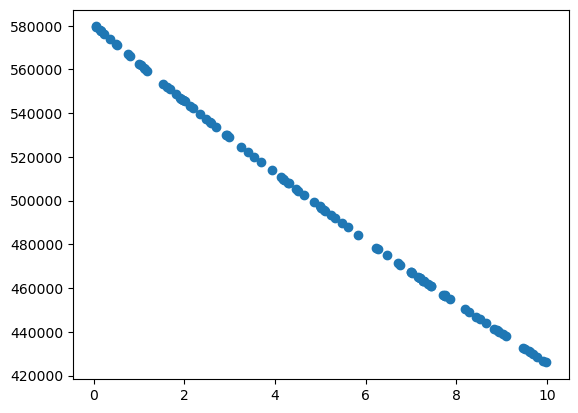

In [31]:
plt.scatter(true_t, p_l)

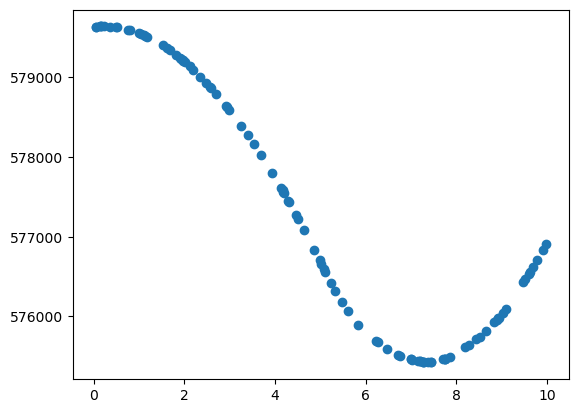

In [32]:
plt.scatter(true_t, P[:,])